In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [04:05<00:00, 19.4MB/s]
100% 5.20G/5.20G [04:05<00:00, 22.8MB/s]


In [ ]:
!unzip /content/skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [ ]:
import pandas as pd
import os
import tensorflow as tf
import keras.preprocessing
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import glob
from tqdm import tqdm

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D


In [ ]:
import os

# Define the source folders
source_folder1 = '/content/HAM10000_images_part_1'
source_folder2 = '/content/HAM10000_images_part_2'

# Define the destination folder
destination_folder = '/content/HAM10000_merged'

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Loop through files in both source folders
for source_folder in [source_folder1, source_folder2]:
  for filename in os.listdir(source_folder):
    # Construct the source file path
    source_path = os.path.join(source_folder, filename)

    # Construct the destination file path (avoid overwriting)
    destination_path = os.path.join(destination_folder, filename)
    i = 1
    while os.path.exists(destination_path):  # Check if file already exists
      new_filename, extension = os.path.splitext(filename)
      destination_path = os.path.join(destination_folder, f"{new_filename}_{i}{extension}")
      i += 1

    # Move the file to the destination folder
    os.rename(source_path, destination_path)

print("Files merged successfully!")

Files merged successfully!


In [ ]:
lesion_type_dict = {
    'nv':'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'

}

In [ ]:
data = pd.read_csv('/content/HAM10000_metadata.csv', sep=',')
data = data.sort_values(by='image_id')
data

,lesion_id,image_id,dx,dx_type,age,sex,localization
4349,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk
4263,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity
4217,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk
3587,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk
1451,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest
...,...,...,...,...,...,...,...
1721,HAM_0004304,ISIC_0034316,mel,histo,85.0,male,upper extremity
1888,HAM_0006376,ISIC_0034317,mel,histo,70.0,female,lower extremity
121,HAM_0000344,ISIC_0034318,bkl,histo,55.0,male,trunk
7440,HAM_0000747,ISIC_0034319,nv,histo,30.0,male,trunk


In [ ]:


# Now, 'data' has the DataFrame with sorted image IDs
# data  # Print the first few rows to verify sorting
data['path'] = "/content/HAM10000_merged/"+data['image_id'] +".jpg"
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['dx_class_index'] = pd.Categorical(data['dx']).codes
data



,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,dx_class_index
4349,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk,/content/HAM10000_merged/ISIC_0024306.jpg,Melanocytic Nevi,5
4263,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity,/content/HAM10000_merged/ISIC_0024307.jpg,Melanocytic Nevi,5
4217,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk,/content/HAM10000_merged/ISIC_0024308.jpg,Melanocytic Nevi,5
3587,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk,/content/HAM10000_merged/ISIC_0024309.jpg,Melanocytic Nevi,5
1451,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest,/content/HAM10000_merged/ISIC_0024310.jpg,Melanoma,4
...,...,...,...,...,...,...,...,...,...,...
1721,HAM_0004304,ISIC_0034316,mel,histo,85.0,male,upper extremity,/content/HAM10000_merged/ISIC_0034316.jpg,Melanoma,4
1888,HAM_0006376,ISIC_0034317,mel,histo,70.0,female,lower extremity,/content/HAM10000_merged/ISIC_0034317.jpg,Melanoma,4
121,HAM_0000344,ISIC_0034318,bkl,histo,55.0,male,trunk,/content/HAM10000_merged/ISIC_0034318.jpg,Benign keratosis-like lesions,2
7440,HAM_0000747,ISIC_0034319,nv,histo,30.0,male,trunk,/content/HAM10000_merged/ISIC_0034319.jpg,Melanocytic Nevi,5


In [ ]:
perwakilan_per_kelas = data.groupby('dx').first().reset_index()

# Menampilkan perwakilan dari masing-masing kelas
# print(perwakilan_per_kelas)

# Menampilkan perbandingan antara 'dx' dan 'dx_class_index'
print("\nPerbandingan 'dx' dan 'dx_class_index' (perwakilan):")
print(perwakilan_per_kelas[['dx','cell_type', 'dx_class_index']])


Perbandingan 'dx' dan 'dx_class_index' (perwakilan):
      dx                       cell_type  dx_class_index
0  akiec               Actinic keratoses               0
1    bcc            Basal cell carcinoma               1
2    bkl  Benign keratosis-like lesions                2
3     df                  Dermatofibroma               3
4    mel                        Melanoma               4
5     nv                Melanocytic Nevi               5
6   vasc                Vascular lesions               6


In [ ]:
jumlah_kelas = data['dx'].nunique()
print("Jumlah kelas:", jumlah_kelas)

jumlah_data_per_kelas = data['dx'].value_counts()
print("Jumlah data per kelas:")
jumlah_data_per_kelas


Jumlah kelas: 7
Jumlah data per kelas:


dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

<Axes: xlabel='dx'>

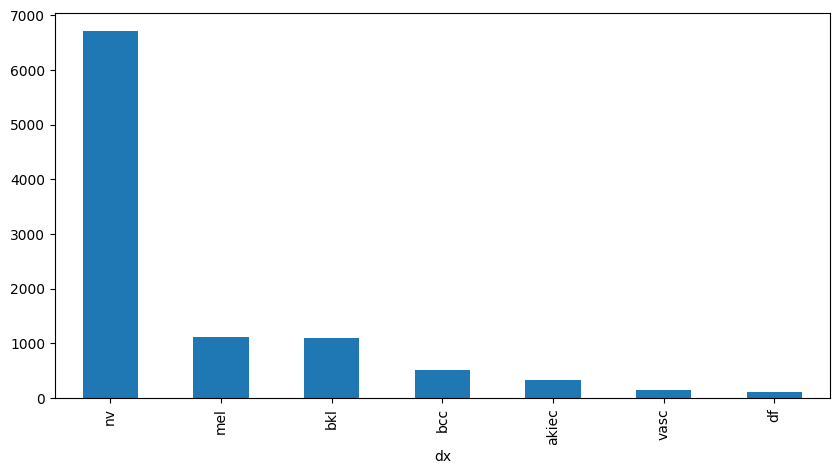

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
data['dx'].value_counts().plot(kind='bar', ax=ax1)


In [ ]:
y = data['dx_class_index']
x = data.drop(columns = ['dx_class_index'])

In [ ]:
IMAGE_SIZE = 128
def read_img(img_path):
  img = cv2.imread(img_path,cv2.IMREAD_COLOR)
  img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE))
  return img
train_img = []
for img_name in tqdm(data['path'].values):
  train_img.append(read_img(img_name))

100%|██████████| 10015/10015 [01:41<00:00, 98.46it/s] 


In [ ]:
X = np.array(train_img,np.float32)/255
print(X.shape)

(10015, 128, 128, 3)


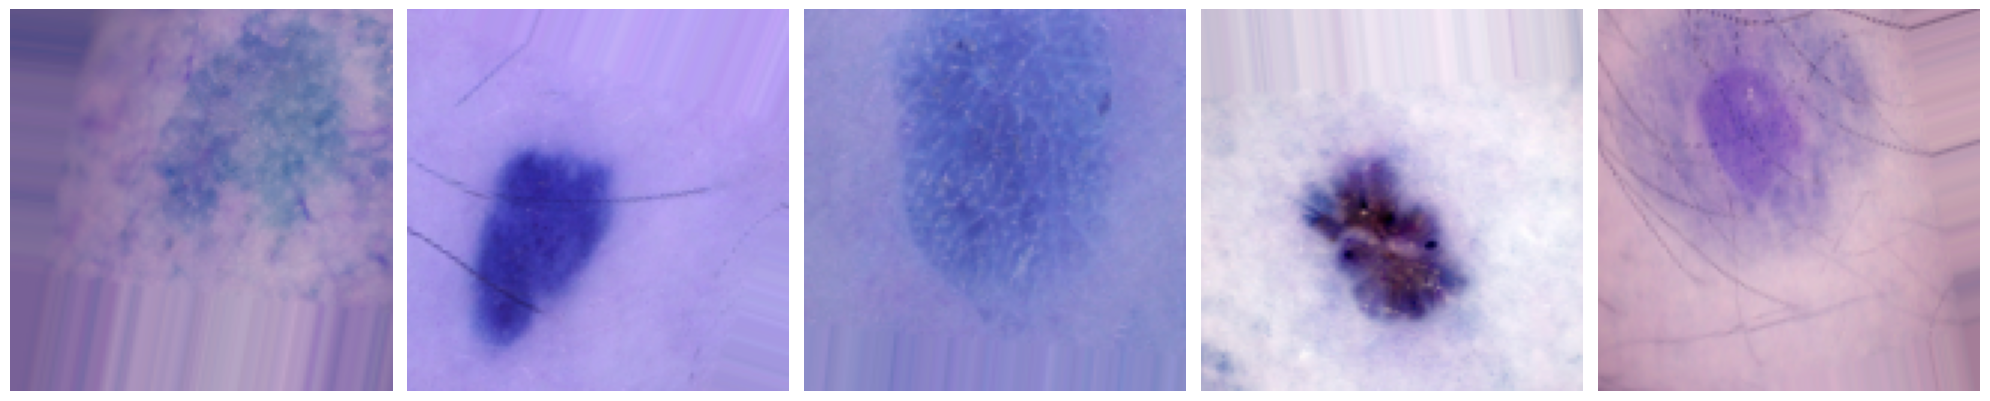

In [ ]:
# Membuat ImageDataGenerator untuk augmentasi data
datagen = ImageDataGenerator(
    rotation_range=20,         # Rotasi acak hingga 20 derajat
    width_shift_range=0.2,     # Perpindahan horizontal acak sebesar 20% dari lebar
    height_shift_range=0.2,    # Perpindahan vertikal acak sebesar 20% dari tinggi
    shear_range=0.2,           # Shearing transformation acak
    zoom_range=0.2,            # Zoom acak dalam range 20%
    horizontal_flip=True,      # Membalik gambar secara horizontal secara acak
    fill_mode='nearest'        # Mengisi piksel yang hilang setelah augmentasi
)

# Menyiapkan iterator untuk data augmentasi
augmented_data = datagen.flow(X, y, batch_size=32)

# Contoh: Menghasilkan dan menampilkan gambar augmentasi dari batch pertama
import matplotlib.pyplot as plt

# Mengambil batch pertama dari augmented_data
batch = next(augmented_data)
augmented_images, augmented_labels = batch

# Menampilkan beberapa gambar augmentasi
fig, axes = plt.subplots(1, 5, figsize=(20, 20))
axes = axes.flatten()

for img, ax in zip(augmented_images[:5], axes):
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()


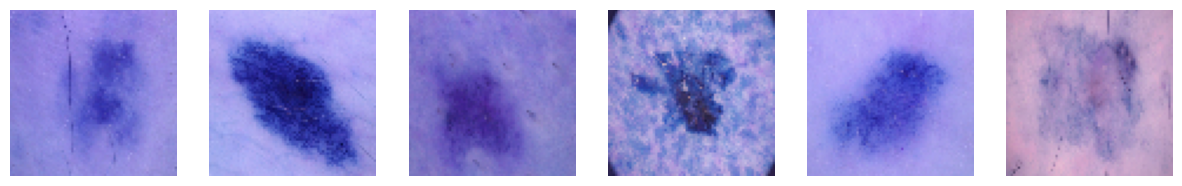

In [ ]:
#Visulaizing the normalized images
plt.figure(figsize=(15,12))
for i in range(1,7,1):
    plt.subplot(1,6,i)
    plt.imshow(X[i])
    plt.axis('off')
plt.show()

In [ ]:
y = np.array(data['dx_class_index'])


In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.10,random_state=28,stratify=y)
x_train,x_val,y_train,y_val =   train_test_split(x_train,y_train,test_size=0.10,random_state=28,stratify=y_train)

In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from keras.applications import Xception,VGG16,ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.models import Sequential, Model

In [ ]:
y_train = to_categorical(y_train, num_classes = 7)
y_val = to_categorical(y_val , num_classes=7)
y_test =to_categorical(y_test , num_classes=7)

In [ ]:
# Defining base model using Xception module from Keras
training_shape = (71,71,3)
base_model = Xception(include_top=False,weights='imagenet',input_shape = training_shape)
for layer in base_model.layers:
    layer.trainable = True                         # Training all layers from scratch

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
#Adding layers at end
n_classes = 7
model = base_model.output
model = Flatten()(model)
model = Dense(128)(model)
model = Dropout(0.5)(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
output = Dense(n_classes, activation='softmax')(model)
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Compiling the model
optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 71, 71, 3)]          0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 35, 35, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 35, 35, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 35, 35, 32)           0         ['block1_conv1_bn[0][0]'] 

In [ ]:
# Defining callback Methods
n_epoch = 30

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1,
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,
                              verbose=1, mode='auto')

In [ ]:
# Fitting the model
history = model.fit(x_train,
                    y_train,
                    epochs=n_epoch,
                    callbacks=[reduce_lr,early_stop],
                    validation_data=(x_val,y_val)
                   )

Epoch 1/30
254/254 [==============================] - 89s 98ms/step - loss: 0.8853 - accuracy: 0.7034 - val_loss: 0.8720 - val_accuracy: 0.7395 - lr: 0.0010
Epoch 2/30
254/254 [==============================] - 22s 85ms/step - loss: 0.6776 - accuracy: 0.7669 - val_loss: 0.6965 - val_accuracy: 0.7738 - lr: 0.0010
Epoch 3/30
254/254 [==============================] - 26s 103ms/step - loss: 0.5788 - accuracy: 0.8047 - val_loss: 0.5977 - val_accuracy: 0.7882 - lr: 0.0010
Epoch 4/30
254/254 [==============================] - 23s 89ms/step - loss: 0.4832 - accuracy: 0.8331 - val_loss: 0.6534 - val_accuracy: 0.7705 - lr: 0.0010
Epoch 5/30
254/254 [==============================] - 23s 89ms/step - loss: 0.4065 - accuracy: 0.8604 - val_loss: 0.7347 - val_accuracy: 0.7816 - lr: 0.0010
Epoch 6/30
254/254 [==============================] - 23s 89ms/step - loss: 0.3230 - accuracy: 0.8898 - val_loss: 0.7105 - val_accuracy: 0.7805 - lr: 0.0010
Epoch 7/30
254/254 [==============================] - 23s

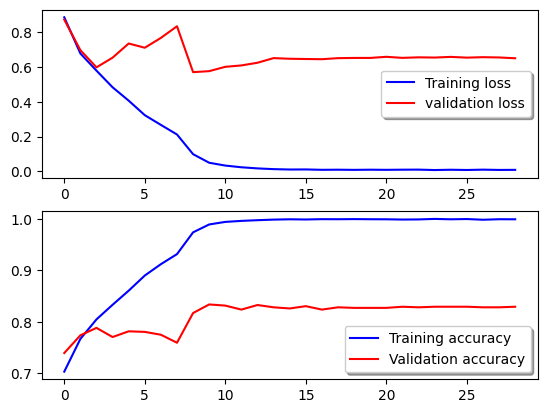

In [ ]:
# Plotting the results on Graph
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
train_loss = history.history['loss'][-1] * 100
val_loss = history.history['val_loss'][-1] * 100
train_acc = history.history['accuracy'][-1] * 100
val_acc = history.history['val_accuracy'][-1] * 100

# Print results
print(f"Training Accuracy: {train_acc:.2f}%")
print(f"Validation Accuracy: {val_acc:.2f}%")
print(f"Training Loss: {train_loss:.2f}%")
print(f"Validation Loss: {val_loss:.2f}%")


Training Accuracy: 99.89%
Validation Accuracy: 82.93%
Training Loss: 0.88%
Validation Loss: 65.00%


In [ ]:
# Get the train accuracy
train_loss, train_accuracy = model.evaluate(x_train, y_train)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

# Get the val accuracy
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
scores = model.evaluate(x_test, y_test)

test_loss_percentage = test_loss *100
test_acc_percentage = test_accuracy *100

print(f"Test Loss: {test_loss_percentage:.2f}%")
print(f"Test Accuracy:{test_acc_percentage:.2f}%")

254/254 [==============================] - 6s 23ms/step - loss: 0.0454 - accuracy: 0.9956
Train Loss: 0.045420773327350616
Train Accuracy: 0.9955615997314453
29/29 [==============================] - 1s 29ms/step - loss: 0.5702 - accuracy: 0.8171
Val Loss: 0.5701714754104614
Val Accuracy: 0.8170731663703918
32/32 [==============================] - 1s 26ms/step - loss: 0.5562 - accuracy: 0.8204
Test Loss: 55.62%
Test Accuracy:82.04%


32/32 [==============================] - 1s 20ms/step
Classification Report:
              precision    recall  f1-score   support

       akiec       0.52      0.67      0.59        33
         bcc       0.68      0.67      0.67        51
         bkl       0.62      0.68      0.65       110
          df       0.80      0.67      0.73        12
         mel       0.58      0.60      0.59       111
          nv       0.93      0.90      0.92       671
        vasc       0.75      0.86      0.80        14

    accuracy                           0.82      1002
   macro avg       0.70      0.72      0.71      1002
weighted avg       0.83      0.82      0.82      1002

Confusion Matrix:


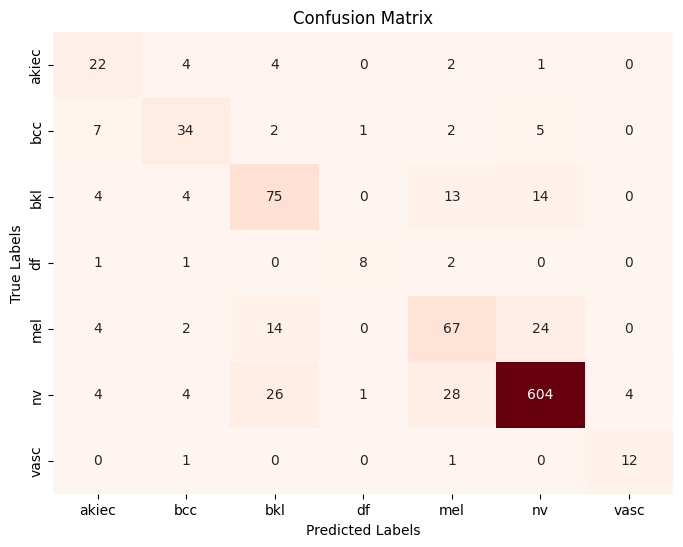

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Prediksi pada data uji
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
test_pred = model.predict(x_test)
test_pred = np.argmax(test_pred, axis=1)
test_label = np.argmax(y_test, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(test_label, test_pred, target_names=targetnames))

# Confusion Matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(test_label, test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=targetnames, yticklabels=targetnames, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Saving bcc.jpeg to bcc.jpeg


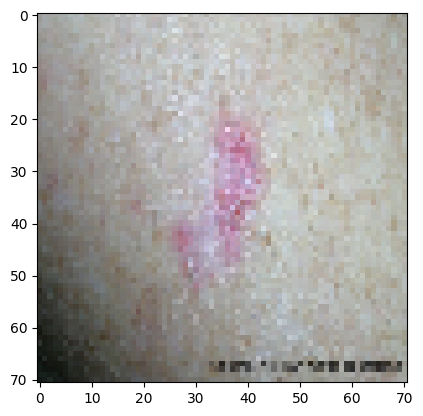

1/1 [==============================] - 0s 27ms/step
bcc.jpeg
Prediction probabilities: [[0.01197529 0.81927496 0.00599276 0.14745946 0.00313949 0.00752747
  0.00463054]]
bcc / Basal cell carcinoma


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files
from tqdm import tqdm

IMAGE_SIZE = 71

# Fungsi untuk membaca dan memproses gambar sesuai dengan preprocessing yang dilakukan sebelumnya
def read_img(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    return img

# Mengunggah file
uploaded = files.upload()

# Memastikan model sudah didefinisikan dan dimuat sebelumnya
# model = ...  # Pastikan model sudah didefinisikan dan dilatih

for fn in uploaded.keys():
    path = fn
    img = read_img(path)  # Menggunakan fungsi preprocessing yang sama

    # Mengubah tipe data gambar ke float32 sebelum normalisasi
    img = img.astype(np.float32) / 255.0  # Normalisasi gambar seperti pada data pelatihan

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

    x = np.expand_dims(img, axis=0)  # Menambahkan dimensi batch

    classes = model.predict(x, batch_size=10)
    print(fn)
    print("Prediction probabilities:", classes)

    # Asumsi kelas berurutan sebagai [akiec, bcc, bkl, df, mel, nv, vasc]
    class_idx = np.argmax(classes, axis=1)[0]

    if class_idx == 0:
        print("akiec / Actinic keratoses")
    elif class_idx == 1:
        print("bcc / Basal cell carcinoma")
    elif class_idx == 2:
        print("bkl / Benign keratosis-like lesions")
    elif class_idx == 3:
        print("df / Dermatofibroma")
    elif class_idx == 4:
        print("mel / Melanoma")
    elif class_idx == 5:
        print("nv / Melanocytic Nevi")
    elif class_idx == 6:
        print("vasc / Vascular lesion")
    else:
        print("Unknown")



#       dx                       cell_type  dx_class_index
# 0  akiec               Actinic keratoses               0
# 1    bcc            Basal cell carcinoma               1
# 2    bkl  Benign keratosis-like lesions                2
# 3     df                  Dermatofibroma               3
# 4    mel                        Melanoma               4
# 5     nv                Melanocytic Nevi               5
# 6   vasc                Vascular lesions               6